In [46]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [47]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 10
    num_classes = 29
    img_channels = 3
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

 Data Exploration

In [49]:
# Labels
TRAIN_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.remove('J')
labels.remove('Z')

print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [50]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

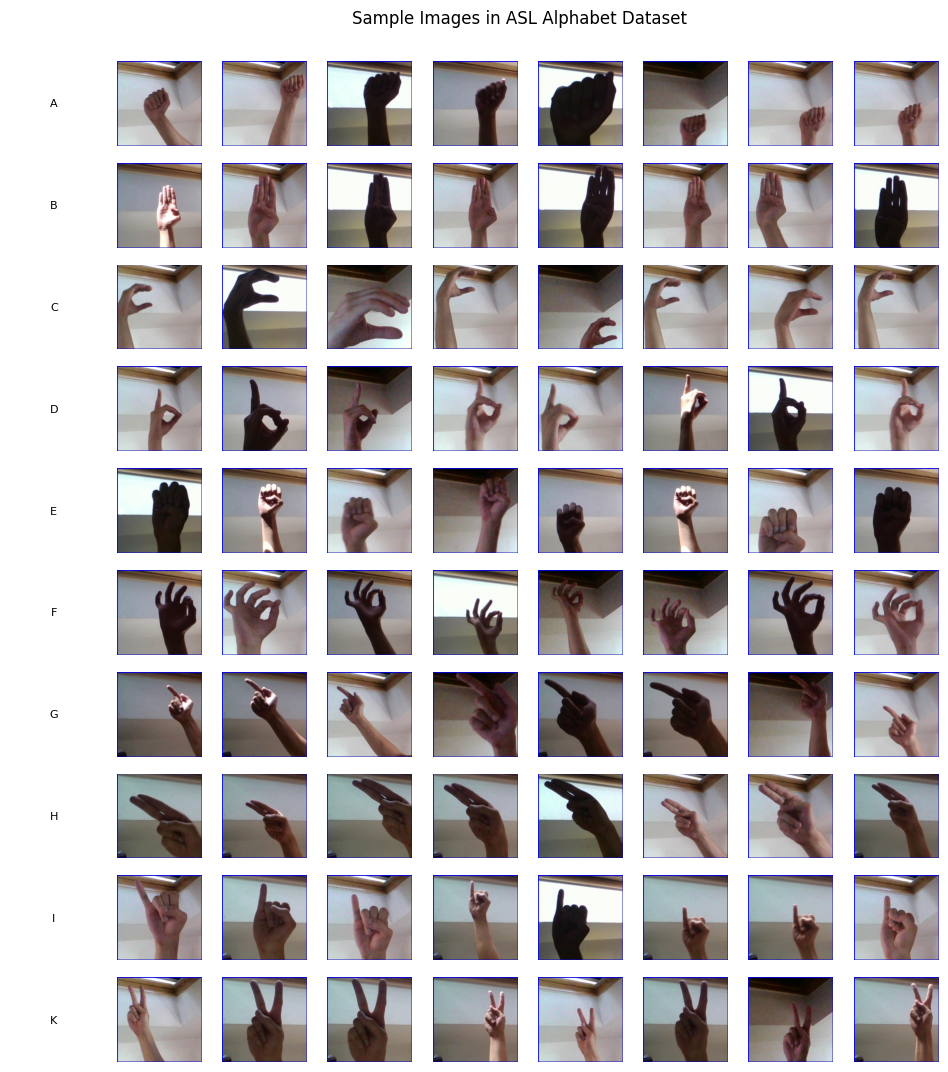

In [51]:
sample_images(labels[:10])

 Data Preprocessing

In [53]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
...,...,...
71995,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
71996,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
71997,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
71998,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y


In [54]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
40282,/kaggle/input/asl-alphabet/asl_alphabet_train/...,O
19843,/kaggle/input/asl-alphabet/asl_alphabet_train/...,G
14301,/kaggle/input/asl-alphabet/asl_alphabet_train/...,E
36747,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
45398,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Q
...,...,...
51642,/kaggle/input/asl-alphabet/asl_alphabet_train/...,S
28505,/kaggle/input/asl-alphabet/asl_alphabet_train/...,K
35409,/kaggle/input/asl-alphabet/asl_alphabet_train/...,M
34626,/kaggle/input/asl-alphabet/asl_alphabet_train/...,M


,image_path,label
4459,/kaggle/input/asl-alphabet/asl_alphabet_train/...,B
15075,/kaggle/input/asl-alphabet/asl_alphabet_train/...,F
61326,/kaggle/input/asl-alphabet/asl_alphabet_train/...,V
59015,/kaggle/input/asl-alphabet/asl_alphabet_train/...,U
26199,/kaggle/input/asl-alphabet/asl_alphabet_train/...,I
...,...,...
23980,/kaggle/input/asl-alphabet/asl_alphabet_train/...,H
55873,/kaggle/input/asl-alphabet/asl_alphabet_train/...,T
67160,/kaggle/input/asl-alphabet/asl_alphabet_train/...,X
45179,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Q


,image_path,label
53851,/kaggle/input/asl-alphabet/asl_alphabet_train/...,S
70520,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
58029,/kaggle/input/asl-alphabet/asl_alphabet_train/...,U
19728,/kaggle/input/asl-alphabet/asl_alphabet_train/...,G
8267,/kaggle/input/asl-alphabet/asl_alphabet_train/...,C
...,...,...
15488,/kaggle/input/asl-alphabet/asl_alphabet_train/...,F
31913,/kaggle/input/asl-alphabet/asl_alphabet_train/...,L
68122,/kaggle/input/asl-alphabet/asl_alphabet_train/...,X
19159,/kaggle/input/asl-alphabet/asl_alphabet_train/...,G


In [55]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [56]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 48085 validated image filenames belonging to 24 classes.
Found 13115 validated image filenames belonging to 24 classes.
Found 10800 validated image filenames belonging to 24 classes.


#### Model VGG16

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

None

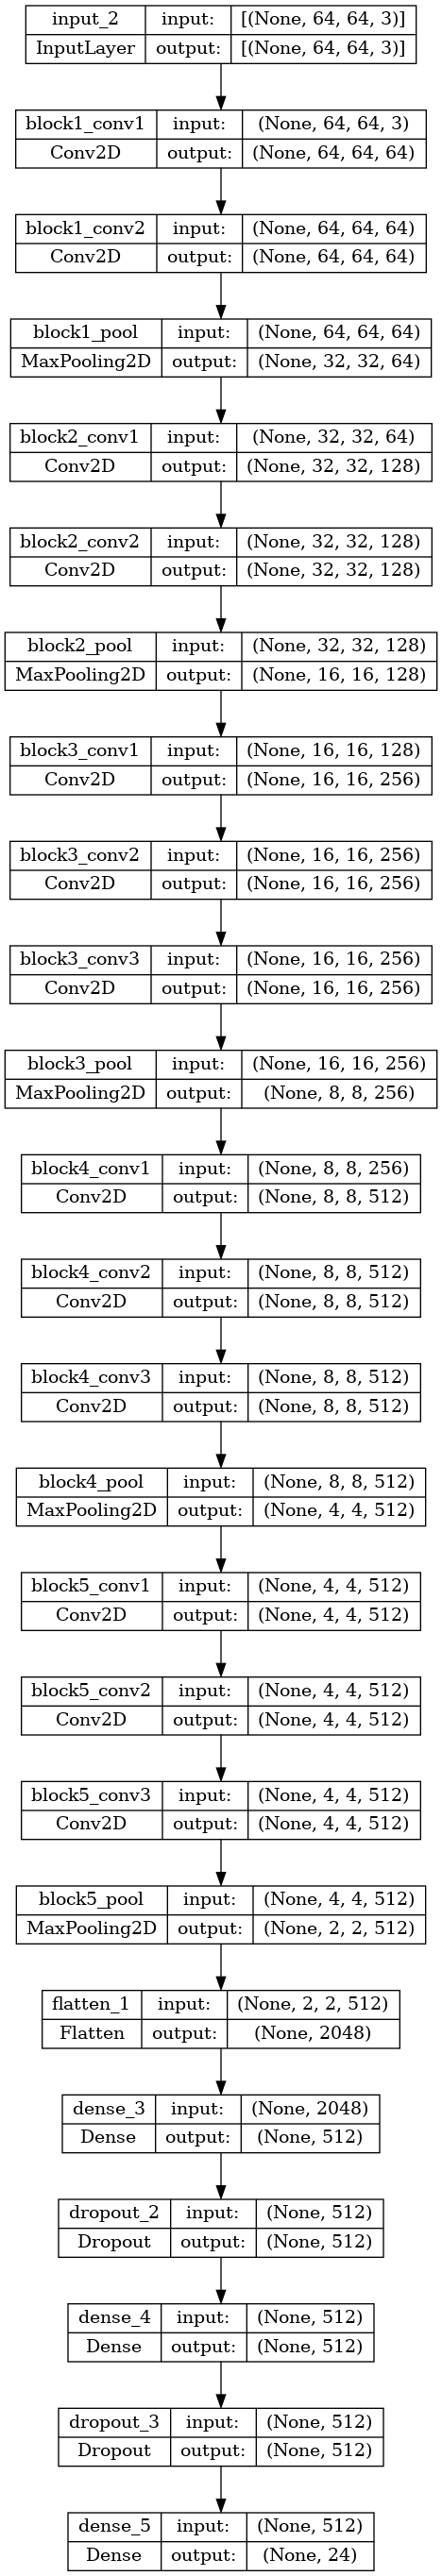

In [63]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(24, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

#### Training

In [64]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [66]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/50
751/751 [==============================] - 86s 114ms/step - loss: 0.1405 - accuracy: 0.9518 - val_loss: 0.0450 - val_accuracy: 0.9843
Epoch 2/50
751/751 [==============================] - 78s 103ms/step - loss: 0.1406 - accuracy: 0.9528 - val_loss: 0.0255 - val_accuracy: 0.9930
Epoch 3/50
751/751 [==============================] - 81s 108ms/step - loss: 0.1351 - accuracy: 0.9540 - val_loss: 0.0258 - val_accuracy: 0.9926
Epoch 4/50
751/751 [==============================] - 90s 120ms/step - loss: 0.1291 - accuracy: 0.9574 - val_loss: 0.0258 - val_accuracy: 0.9917
Epoch 5/50
751/751 [==============================] - 94s 125ms/step - loss: 0.1215 - accuracy: 0.9596 - val_loss: 0.0257 - val_accuracy: 0.9938
Epoch 6/50
751/751 [==============================] - 91s 121ms/step - loss: 0.1297 - accuracy: 0.9570 - val_loss: 0.0279 - val_accuracy: 0.9920
Epoch 7/50
751/751 [==============================] - 86s 114ms/step - loss: 0.1178 - accuracy: 0.9599 - val_loss: 0.0246 - val_ac

#### Model Testing

In [67]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

10800/10800 [==============================] - 73s 7ms/step - loss: 0.0139 - accuracy: 0.9956
Evaluate Test Accuracy: 99.56%


####  Training Loss and Metrics

In [68]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "#76503d"
    valid_color = "#deb392"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

#### Confusion Matrix

In [70]:
# Confusion Matrix
fine_tuned_model = load_model("/kaggle/working/asl_vgg16_best_weights.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=24)

10800/10800 [==============================] - 46s 4ms/step


In [71]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=labels,
        y=labels,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050, 
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

#### TSNE

In [72]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [73]:
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [74]:
# Extract Features in Dense Layer
def dense_feature_prediction(img_path):
    img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = data_test[data_test["label"]==label][:100]
    reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)

,image_path,label
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
...,...,...
2395,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
2396,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
2397,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
2398,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y


100%|██████████| 2400/2400 [02:27<00:00, 16.27it/s]


In [75]:
# tSNE Dimensional Reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.003s...
[t-SNE] Computed neighbors for 2400 samples in 0.320s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 7.108642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.082844
[t-SNE] KL divergence after 1000 iterations: 0.526043


,image_path,label,tsne_feat_0,tsne_feat_1
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,-3.005063,10.853216
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,-1.509436,16.802542
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,-4.348803,13.291132
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,1.087734,12.770275
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,-2.761983,11.150067
...,...,...,...,...
2395,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y,-41.801453,-4.310523
2396,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y,-40.883846,-6.688679
2397,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y,-43.656124,-3.764080
2398,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y,-41.603851,-5.299911


In [76]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000", 
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show()